### Hypothesis Testing Notebook

In [4]:

import numpy as np 
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import chi2, chi2_contingency


import math as mt
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

In [5]:
data = pd.read_csv("/kaggle/input/ab-testing/AdSmartABdata.csv")

In [6]:
control = data[data['experiment'] == 'control']
exposed = data[data['experiment'] == 'exposed']

In [7]:
control =control.reset_index(drop=True)
control

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
1,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
2,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0
3,002e308b-1a07-49d6-8560-0fbcdcd71e4b,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
4,00393fb9-ca32-40c0-bfcb-1bd83f319820,control,2020-07-09,5,Samsung SM-G973F,6,Facebook,0,0
...,...,...,...,...,...,...,...,...,...
4066,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1
4067,ffcea781-a6e7-4f98-9d90-f95377270476,control,2020-07-03,15,Samsung SM-N976B,6,Facebook,0,0
4068,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
4069,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0


In [8]:
exposed =exposed.reset_index(drop=True)
exposedParticipate = exposed[~((exposed['yes']== 0) & (exposed['no']== 0))]
exposedNotParticipate =  exposed[(exposed['yes']== 0) & (exposed['no']== 0)]
control =control.reset_index(drop=True)
controlParticipate = control[~((control['yes']== 0) & (control['no']== 0))]
controlNotParticipate =  control[(control['yes']== 0) & (control['no']== 0)]

In [9]:
print(len(exposedParticipate))
print(len(exposedNotParticipate))
print(len(exposed))

657
3349
4006


In [10]:
print(len(controlParticipate))
print(len(controlNotParticipate))
print(len(control))

586
3485
4071


In [11]:
exposedParticipate= exposedParticipate.drop(columns='no')
controlParticipate= controlParticipate.drop(columns='no')
exposedNotParticipate= exposedNotParticipate.drop(columns='no')
controlNotParticipate= controlNotParticipate.drop(columns='no')

In [12]:
controlParticipate['clicked'] = 1
exposedParticipate['clicked'] = 1
controlNotParticipate['clicked']= 0
exposedNotParticipate['clicked'] = 0 

In [13]:
controlParticipate=controlParticipate.append(controlNotParticipate,ignore_index = True)
exposedParticipate=exposedParticipate.append(exposedNotParticipate,ignore_index = True)

In [14]:
exposedParticipate = exposedParticipate.rename(columns={'yes': 'aware'})
controlParticipate = controlParticipate.rename(columns={'yes': 'aware'})

In [15]:
print(len(controlParticipate))
print(len(exposedParticipate))

4071
4006


In [16]:
metrics_control = controlParticipate[['date','clicked','aware', 'experiment']]
metrics_exposed = exposedParticipate[['date','clicked','aware','experiment']]

In [17]:
total =metrics_control.append(metrics_exposed)

In [18]:
total=total.groupby('experiment').sum()

In [19]:
total.loc['control', 'users' ]= 4071
total.loc['exposed', 'users' ]= 4006
total= total.T
total=total.sort_values('control', ascending=False)

In [20]:
total

experiment,control,exposed
users,4071.0,4006.0
clicked,586.0,657.0
aware,264.0,308.0


In [21]:
control_user = total.loc['users','control']
control_clicks = total.loc['clicked','control']
control_aware = total.loc['aware', 'control']

exp_user = total.loc['users','exposed']
exp_clicks = total.loc['clicked', 'exposed']
exp_aware = total.loc['aware', 'exposed']

user_total = control_user + exp_user
clicks_total = control_clicks + exp_clicks
aware_total = control_aware + exp_aware

### Sanity Check on our total number of Users


In [22]:
def get_z_score(alpha):
    return norm.ppf(alpha)

In [23]:
p=0.5
alpha=0.05
p_hat=round(control_user/(user_total),4)
sd=mt.sqrt(p*(1-p)/(user_total))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4891 and 0.5109 ; Is 0.504 inside this range?


In [44]:
ME

0.7689

Yes it is so we can move to checking if the Click in our data  

In [24]:
p_hat=round(control_clicks/clicks_total,4)
sd=mt.sqrt(p*(1-p)/clicks_total)
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4722 and 0.5278 ; Is 0.4714 inside this range?


yes it is so we have passed another sanity check since clicks in the control in the range of our upper and lower interval

 Next we check the Click through Probability

In [25]:
control_ctp = control_clicks / control_user
exp_ctp = exp_clicks / exp_user
d_hat = round(exp_ctp - control_ctp,4)
p_pooled =  clicks_total/ user_total
sd_pooled = np.sqrt(p_pooled * (1 - p_pooled * (1 / control_user + 1 / exp_user)))
ME=round(get_z_score(1-(alpha/2))*sd_pooled,4)
print ("The confidence interval is between",0-ME,"and",0+ME,"and d_hat is",d_hat)

The confidence interval is between -0.7689 and 0.7689 and d_hat is 0.0201


The Click Through Probability which represents the number of people who filled our survey is around the same confidence interval for both Control and Exposed, we can now start our Analysis

### We can now do our analysis for the increase in the number of yes, which is our metrics to prove increase in Brand Awareness, we would use Parametric and Non Parametric Methods

 > ### Parametric Method

In [26]:
AW_cont= control_aware/control_clicks
AW_exp=exp_aware/exp_clicks
AW_pooled=(control_aware+exp_aware)/(control_clicks+exp_clicks)
AW_sd_pooled=mt.sqrt(AW_pooled*(1-AW_pooled)*(1/control_clicks+1/exp_clicks))
AW_ME=round(get_z_score(1-alpha/2)*AW_sd_pooled,4)
AW_diff=round(AW_exp-AW_cont,4)
print("The change due to the experiment is",AW_diff*100,"%")
print("Confidence Interval: [",AW_diff-AW_ME,",",AW_diff+AW_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0.")

The change due to the experiment is 1.83 %
Confidence Interval: [ -0.0372 , 0.0738 ]
The change is statistically significant if the CI doesn't include 0.


According to this result there was a change due to the experiment,the change include zero which means it is not statistically significant, it still occurs in the range of our Control Data


In [27]:
l = metrics_control.groupby('date').sum()
n = metrics_exposed.groupby('date').sum()

In [28]:
n

,clicked,aware
date,,
2020-07-03,92,43
2020-07-04,91,46
2020-07-05,74,35
2020-07-06,48,23
2020-07-07,46,22
2020-07-08,119,58
2020-07-09,119,55
2020-07-10,68,26


In [29]:
 metrics =l.join(n, on=None, how='left', lsuffix='_contr', rsuffix='_expos', sort=False)

In [30]:
metrics

,clicked_contr,aware_contr,clicked_expos,aware_expos
date,,,,
2020-07-03,233,104,92,43
2020-07-04,68,30,91,46
2020-07-05,43,17,74,35
2020-07-06,26,12,48,23
2020-07-07,37,16,46,22
2020-07-08,58,27,119,58
2020-07-09,65,30,119,55
2020-07-10,56,28,68,26


Let us try to find the change perday for our metric


In [31]:
# Perfect! Now, derive a new column for each metric, so we have it's daily values
# We need a 1 if the experiment value is greater than the control value
metrics['rate_aware_cont']=metrics['aware_contr']/metrics['clicked_contr']
metrics['rate_aware_exp']=metrics['aware_expos']/metrics['clicked_expos']
metrics['AW'] = np.where(metrics['rate_aware_cont']< metrics['rate_aware_exp'],1,0)
metrics

,clicked_contr,aware_contr,clicked_expos,aware_expos,rate_aware_cont,rate_aware_exp,AW
date,,,,,,,
2020-07-03,233,104,92,43,0.446352,0.467391,1
2020-07-04,68,30,91,46,0.441176,0.505495,1
2020-07-05,43,17,74,35,0.395349,0.472973,1
2020-07-06,26,12,48,23,0.461538,0.479167,1
2020-07-07,37,16,46,22,0.432432,0.478261,1
2020-07-08,58,27,119,58,0.465517,0.487395,1
2020-07-09,65,30,119,55,0.461538,0.462185,1
2020-07-10,56,28,68,26,0.500000,0.382353,0


In [32]:
aw_x = metrics.AW[metrics['AW']==1].count()
n = metrics.AW.count()


We notice and increase in awareness of our brand almost everyday, except on the 10th which is the last day and assumption are that maybe we stopped early

In [33]:
def get_prob(x,n):
    p=round(mt.factorial(n)/(mt.factorial(x)*mt.factorial(n-x))*0.5**x*0.5**(n-x),4)
    return p
#next a function to compute the pvalue from probabilities of maximum x
def get_2side_pvalue(x,n):
    p=0
    for i in range(0,x+1):
        p=p+get_prob(i,n)
    return 2*p

In [34]:
print ("Awareness Change is significant if",get_2side_pvalue(aw_x,n),"is greater than 0.05")

Awareness Change is significant if 1.9921999999999997 is greater than 0.05


There was an increase everyday, which was measured here, but the increase wasn't much across board, the Binomial Probability cannot measure this efffectively, we are not taking this into account

### Sequential Testing of our Hypothesis 

### Importing a library that would make it easier to do sequential testing

In [35]:
!pip install git+https://github.com/dmarinere/Sequential-Probability-Ratio-Test

  Cloning https://github.com/dmarinere/Sequential-Probability-Ratio-Test to /tmp/pip-req-build-9x191htr
  Running command git clone -q https://github.com/dmarinere/Sequential-Probability-Ratio-Test /tmp/pip-req-build-9x191htr
  Created wheel for sprt: filename=sprt-0.0.1-py3-none-any.whl size=4644 sha256=9648c69a75a4c325c4423d12034835ab9a4b427823de44d6ca2c2ac417094278
  Stored in directory: /tmp/pip-ephem-wheel-cache-yojis0n6/wheels/51/eb/30/73b74682c4ebd1afa989eb1c691736ff0ab5c514958b7c6eb8
Successfully built sprt
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [36]:
import sprt as sprt

In [38]:
total

experiment,control,exposed
users,4071.0,4006.0
clicked,586.0,657.0
aware,264.0,308.0


Creating our null and Alternative Hypothesis

In [39]:
h0 = control_clicks/clicks_total
h1 = exp_clicks/clicks_total

Creating our values data which signify those who participated in the survey

In [40]:
values = control.yes[~((control['yes']== 0) & (control['no']== 0))].values


In [41]:

# Type I error rate = 0.05
alpha = 0.05
# Type II error rate = 0.2
beta = 0.2
test = sprt.SPRTBinomial(h0 = h0, h1 = h1, alpha = alpha, beta = beta, values = values)

Decision:	Accept

     values    lower    upper
n                            
557     250  271.688  290.622
558     251  272.188  291.122
559     252  272.688  291.622
560     253  273.188  292.122
561     254  273.688  292.622
562     254  274.188  293.122
563     255  274.688  293.622
564     255  275.188  294.122
565     255  275.688  294.622
566     255  276.188  295.122
567     255  276.688  295.622
568     255  277.188  296.122
569     256  277.688  296.622
570     257  278.188  297.122
571     257  278.688  297.622
572     258  279.188  298.122
573     258  279.688  298.622
574     259  280.188  299.122
575     260  280.688  299.622
576     261  281.188  300.122
577     261  281.688  300.622
578     262  282.188  301.122
579     262  282.688  301.622
580     262  283.188  302.122
581     262  283.688  302.622
582     263  284.188  303.122
583     263  284.688  303.622
584     264  285.188  304.122
585     264  285.688  304.622
586     264  286.188  305.122


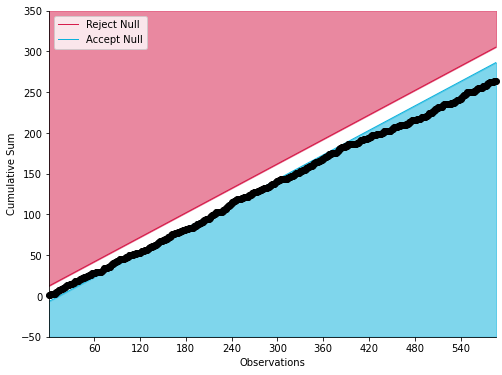

In [43]:
test.plot()